In [1]:
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fred = Fred(api_key="d0b19bd01f39fdd7318477768791c1a9")

In [6]:
import requests
import pandas as pd
from io import BytesIO,StringIO
def get_bls_txt(url):
    response = requests.get(url, headers = {"user-agent":"xinxianwang21@gmail.com"})
    data = StringIO(response.text)
    df = pd.read_csv(data, sep='\t')
    df.columns = df.columns.str.strip()
    return df
            
def order_df(df, list, mapping_df):
    '''Orders a pivot table based on series id list'''
    df = df[df['series_id'].isin(list)]
    df = df.pivot_table(values='value', columns = 'date', index='series_id').reindex(list)
    df = df.merge(mapping_df, on='series_id', how='left')
    df = df.set_index('series_title')
    df = df.drop('series_id',axis=1)
    return df

sa_ids = [
    # 'CUSR0000SA0',  # All items
    # 'CUSR0000SAF1',  # Food
    # 'CUSR0000SAF11',  # Food at home
    # 'CUSR0000SEFV',  # Food away from home
    # 'CUSR0000SA0E',  # Energy
    'CUSR0000SA0L1E',  # All items less food and energy
    # 'CUSR0000SACL1E',  # Commodities less food and energy commodities
    # 'CUSR0000SAA',  # Apparel
    # 'CUSR0000SETA01',  # New vehicles
    # 'CUSR0000SETA02',  # Used cars and trucks
    # 'CUSR0000SAM1',  # Medical care commodities
    # 'CUSR0000SAF116', # Alcoholic Beverages
    # 'CUSR0000SEGA',  # Tobacco and smoking products
    # 'CUSR0000SASLE', # Services less Energy Services
    # 'CUSR0000SAH1',  # Shelter
    # 'CUSR0000SEHA',  # Rent of primary residence
    # 'CUSR0000SEHC',  # Owners' equivalent rent of residences
    # 'CUSR0000SAM2',  # Medical care services
    # 'CUSR0000SEMC01',  # Physicians' services
    # 'CUSR0000SEMD01',  # Hospital services
    # 'CUSR0000SAS4',  # Transportation services
    # 'CUSR0000SETD',  # Motor vehicle maintenance and repair
    # 'CUSR0000SETE',  # Motor vehicle insurance
    # 'CUSR0000SETG01'  # Airline fares
]

## get series id and value df
index_url = 'https://download.bls.gov/pub/time.series/cu/cu.data.0.Current'
df = get_bls_txt(index_url)
df['month'] = df['period'].str.extract(r'(\d{2})')[0]
df = df[(df['month'] != '13') & (df['year'] > 2012)].reset_index()
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'], format='%Y-%m')
df['series_id'] = df['series_id'].str.strip()
df = df[['date', 'series_id', 'value']]

## get series id and names mapping
name_url = 'https://download.bls.gov/pub/time.series/cu/cu.series'
name_df = get_bls_txt(name_url)
name_df = name_df[['series_id','series_title']]
name_df['series_id'] = name_df['series_id'].str.strip()

sa_df = order_df(df, sa_ids, name_df)
sa_df.index = sa_df.index.str.replace(" in U.S. city average, all urban consumers, seasonally adjusted", "", regex=False)
sa_df = sa_df.T
sa_df.index = pd.to_datetime(sa_df.index)
sa_df_mom = (sa_df.pct_change()*100).dropna()
sa_df_mom.tail(1)

/var/folders/v5/0s6lmhmj5qbgv2qbqv79wyh80000gn/T/ipykernel_53340/2632030828.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data, sep='\t')


series_title,All items less food and energy
2024-03-01,0.359039


### Core PCE price index

In [2]:
core_pce = pd.DataFrame({'Core_PCE':fred.get_series('PCEPILFE')})

In [3]:
core_pce_mom = core_pce.pct_change()*100
core_pce_mom_latest = core_pce_mom[core_pce_mom.index.year>2022]
core_pce_mom_latest.plot();

In [6]:
till_date = pd.to_datetime('2024-12-01')
start_date = core_pce.index[-1]
period = pd.DateOffset(months=1) * ((till_date.year - start_date.year) * 12 + till_date.month - start_date.month)
num_month = period.n

In [17]:
fed_target = 1.026
x = (np.power(1.026 * core_pce.iloc[-2] / (core_pce.iloc[-1]*1.0027), 1 / (num_month-1)) - 1)*100
x

Core_PCE    0.188417
dtype: float64

In [25]:
# overwrite to see which target it takes
x= 0.21
future_periods = pd.date_range(start=core_pce.index[-1], periods=11, freq='M')
hypo_values = [(core_pce.iloc[-1] * (1 + x / 100) ** i).values for i in range(1, 12)]
hypo_df = pd.DataFrame(hypo_values, index=future_periods, columns=core_pce.columns)
hypo_df.index = hypo_df.index.to_period('M').to_timestamp() + pd.offsets.MonthBegin(1)
hypo_df

,Core_PCE
2024-02-01,121.061697
2024-03-01,121.315926
2024-04-01,121.570690
2024-05-01,121.825988
2024-06-01,122.081823
2024-07-01,122.338195
2024-08-01,122.595105
2024-09-01,122.852555
2024-10-01,123.110545
2024-11-01,123.369077


In [26]:
fed_projected_pce = pd.concat([core_pce[core_pce.index.year>2021], hypo_df])

,Core_PCE
2024-08-01,2.633848
2024-09-01,2.512103
2024-10-01,2.569043
2024-11-01,2.692891
2024-12-01,2.759710


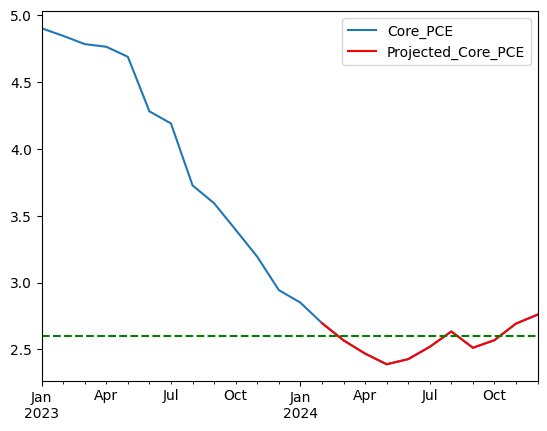

In [27]:
fed_projected_pce_yoy = fed_projected_pce.pct_change(12)*100

data = fed_projected_pce_yoy.dropna()
display(data.tail())
ax = data.plot()

# Highlight portion after '2024-01' with red color
highlight_data = data.loc['2024-02':].copy()
highlight_data.rename({'Core_PCE':'Projected_Core_PCE'},axis=1,inplace=True)
highlight_data.plot(ax=ax, color='red')
plt.axhline(y=2.6, color='green', linestyle='--');

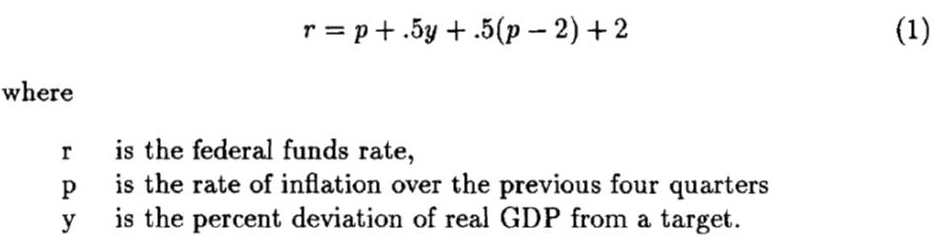

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import requests
import json

api_key = 'C74CD408-26A0-4877-B57A-2226240D66B2'
url = f'https://apps.bea.gov/api/data/?UserID={api_key}&method=GetData&DataSetName=NIPA&TableName=T20804&Frequency=M&Year=All&ResultFormat=JSON'
response = requests.get(url)
json_data  = json.loads(response.text)
df = pd.json_normalize(json_data['BEAAPI'])

In [32]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_excel('https://www.bea.gov/sites/default/files/2024-04/pi0324.xlsx', sheet_name='Table 5', header=4)
df = df[(df['Unnamed: 1'] == 'PCE excluding food and energy') & (df['Line'] == 6) ].reset_index(drop=True)
print(f'{df.columns[-1]} core PCE is {(df[df.columns[-1]][0]/df[df.columns[-2]][0]-1)*100}')
df

March p core PCE is 0.3167506660837649


,Line,Unnamed: 1,Aug.,Sept.,Oct.,Nov.,Dec.,Jan. r,Feb. r,March p
0,6,PCE excluding food and energy,119.449,119.842,120.015,120.122,120.305,120.909,121.231,121.615


In [ ]:
list_of_params = beaapi.get_parameter_list(beakey, 'NIPA')
display(list_of_params)